In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import gget
from sklearn import preprocessing

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

2023-10-12 14:12:44.600369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 14:12:44.703120: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 14:12:44.707534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-12 14:12:44.707548: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

In [2]:
fpath = f"/nfs/turbo/umms-indikar/shared/projects/myod/clean_data/time_series_rna_Z_scores.csv"
raw_path = f"/nfs/turbo/umms-indikar/shared/projects/myod/clean_data/time_series_rna.csv"

""" Load the raw expression """
exf = pd.read_csv(raw_path, index_col=0)
exf = exf.reset_index(drop=False)
exf['replicate'] = exf['index'].apply(lambda x: x.split("_")[1])
exf['time'] = exf['index'].apply(lambda x: x.split("_")[0].replace('T', ''))
print(f"{exf.shape=}")

"""Load the Z-score data frame """
df = pd.read_csv(fpath, index_col=0)
print(f"{df.shape=}")
gene_names = df.columns.to_list()
print(f"{len(gene_names)=}")

# structure the data for DMD
data = df.copy()
dmd_data = hasnain_DMD.data2dmd(data)
print(f"{dmd_data.shape=}")

exf.shape=(48, 23617)
df.shape=(48, 20967)
len(gene_names)=20967
dmd_data.shape=(20967, 16, 3)


# Perform DMD

NOTE, the first measurement is 48 hours before the second, so DMD should be performed on the
next 15 timepoints only

In [3]:
dmd_data = dmd_data[:, :15, :]
print(f"{dmd_data.shape=}")

dmd_data.shape=(20967, 15, 3)


In [4]:
rank = 17 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD
dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
print(dmd_res.keys())

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

dict_keys(['A', 'Atilde', 'rank', 'u_r', 'SVD', 'L', 'W', 'data_embedded', 'Phi', 'Phi_hat', 'amplitudes', 'n', 'm', 'r'])
dmd_res['A'].shape=(20967, 20967)
dmd_res['Atilde'].shape=(17, 17)
dmd_res['u_r'].shape=(20967, 17)
dmd_res['L'].shape=(17,)
dmd_res['W'].shape=(17, 17)
dmd_res['Phi'].shape=(20967, 17)
dmd_res['amplitudes'][0].shape=(17, 15)
done


In [5]:
def gram_matrix(A, x0, nT=50, reduced=True, projection_matrix=np.array([])):
    '''
    A: matrix representation of the Koopman operator
    x0: initial conditions from measurements
    nT: number of timepoints over which to compute the Gram matrix
    reduced: if True, will compute reduced G from reduced data and KO and will also return full G after inverse projection
    projection_matrix: the matrix used to project data and KO to low-dimensional space (first r eigenvectors of Data.T @ Data)
    Both A and x0 can be either the full dimensional data and KO or they can be the DMD projected data and KO
    If projected, then return both the projected G and the full G after inverting the projection
    If not projected, then compute full G (can be slow, especially if the data dimension exceeds a couple thousand)
    Furthermore, for sensor placement we need to compute the eigendecomposition of G, so having the reduced G is handy   
    '''
    # generate artificial initial conditions for robust optimization 
    # get the min and max of each gene's initial value
    x0min = np.min(x0, axis=1)
    x0max = np.max(x0, axis=1)
    # form a set of new initial conditions distributed uniformly from x0min to x0max
    numICs = x0.shape[0]
    x0uni = np.zeros((len(x0min),numICs))
    x0uni[:,0:x0.shape[1]] = deepcopy(x0)
    for ii in range(x0.shape[1], x0uni.shape[1]):
        x0tmp = np.random.uniform(x0min,x0max)
        x0uni[:,ii] = x0tmp

    G = np.zeros_like(A)
    for ii in range(nT):
        print(f"{ii}...")
        A_pow = np.linalg.matrix_power(A,ii)
        G += np.matmul( np.matmul(A_pow, x0uni), np.matmul(x0uni.T, A_pow.T) ) 
    # right eigenvectors of G (columns of V) are rows of the gene sampling matrix (or vector if just one eigvec kept)

    if reduced: 
        Gfull = np.matmul(np.matmul(projection_matrix, G), projection_matrix.T)
        return G, Gfull
    else: 
        return G # this is the full G, computed directly from full KO and data


A = dmd_res['Atilde']
u = dmd_res['u_r']
data_embedded = dmd_res['data_embedded']
nT = 15
G, Gfull = gram_matrix(A, data_embedded[:,0,:], nT=nT, reduced=True, projection_matrix=u)
print(f"{G.shape=} {Gfull.shape=}")

0...
1...
2...
3...
4...
5...
6...
7...
8...
9...
10...
11...
12...
13...
14...
G.shape=(17, 17) Gfull.shape=(20967, 20967)


In [6]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = np.linalg.eig(Gfull)
print(f"{D.shape=}{ V.shape=}")

D.shape=(20967,) V.shape=(20967, 20967)


evals.max()=1315614.8571+0.0000j evals.min()=44756.0763+0.0000j


/home/cstansbu/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


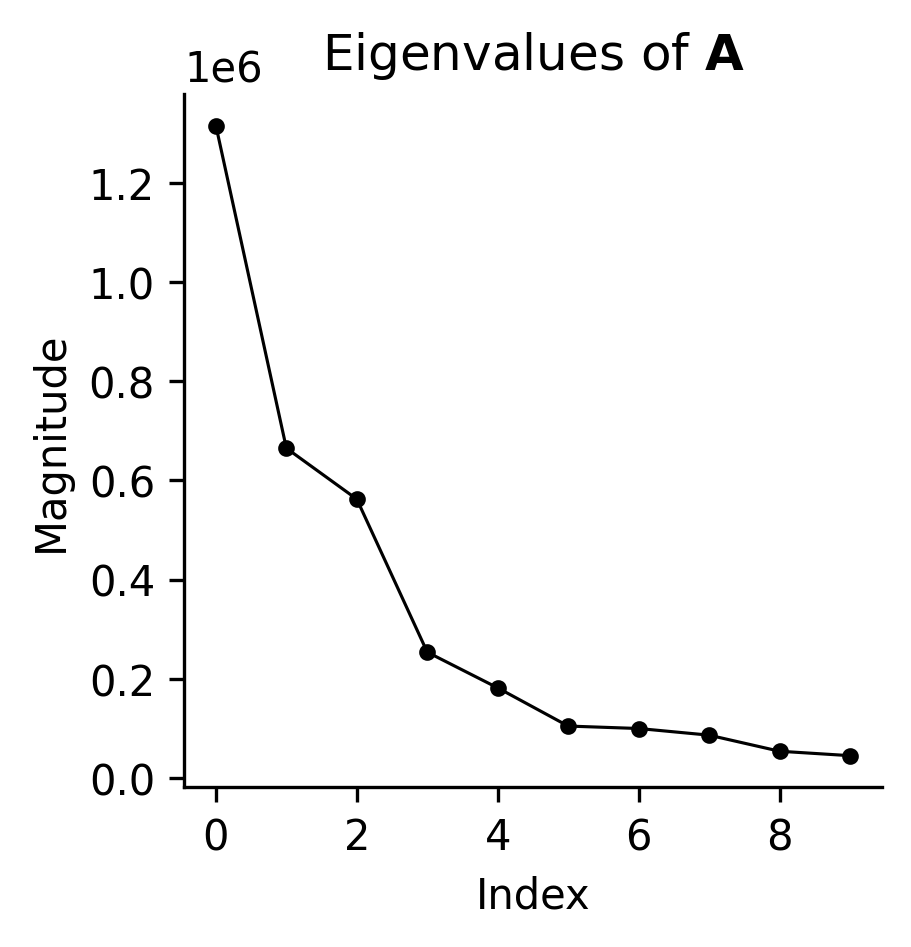

In [7]:
n_val = 10
evals = D[:n_val]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(evals, lw=0.75, c='k', marker=".")
plt.title(r"Eigenvalues of $\mathbf{A}$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

print(f"{evals.max()=:.4f} {evals.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

In [8]:
obs = pd.DataFrame({'gene' : gene_names,
                    'ev1' : V[:,0],
                    'weight' : np.real(V[:,0])})

obs['rank'] = obs['weight'].rank()
obs = obs.sort_values(by='rank', ascending=False)

obs.head(20)

,gene,ev1,weight,rank
3947,CTNNA1,0.013646+0.000000j,0.013646,20967.0
19436,UBE2L3,0.013604+0.000000j,0.013604,20966.0
1271,ATP5G3,0.013572+0.000000j,0.013572,20965.0
10803,MED22,0.013508+0.000000j,0.013508,20964.0
221,ACTR1A,0.013494+0.000000j,0.013494,20963.0
3642,COMMD2,0.013462+0.000000j,0.013462,20962.0
8570,KIAA1967,0.013408+0.000000j,0.013408,20961.0
4998,EIF2B1,0.013366+0.000000j,0.013366,20960.0
18870,TOMM5,0.013343+0.000000j,0.013343,20959.0
18554,TMEM167A,0.013320+0.000000j,0.013320,20958.0


In [22]:
n_gene = 1000
genes = obs['gene'].head(n_gene).to_list()

# db = 'GO_Biological_Process_2023'
# db = 'KEGG_2021_Human'
db = 'TRANSFAC_and_JASPAR_PWMs'

enrich = gget.enrichr(genes, database=db)
pd.set_option('display.max_colwidth', 100)
enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(20)

Thu Oct 12 15:38:09 2023 INFO Performing Enichr analysis using database TRANSFAC_and_JASPAR_PWMs.


,path_name,adj_p_val,overlapping_genes
0,NRF1 (mouse),6.490537e-08,"[MTCH2, DBR1, POP7, VARS, KDM1A, POP1, HNRNPR, PARK7, COX6A1, TOMM22, LAPTM4B, ABHD13, CDC23, MP..."
1,NRF1 (human),1.342074e-04,"[C5ORF24, MTCH2, NUP107, BCCIP, COX6A1, PSMD6, ARHGDIA, AP1S1, ENDOG, MECR, IAH1, CTNNBIP1, COG1..."
2,HIF1A (human),2.517714e-03,"[HNRNPR, ABHD13, CDC23, SNRPD1, FLAD1, PSMD2, RUVBL1, ZNF207, PSMD1, BANF1, SNRNP35, SKP1, AP1B1..."
3,GFI1 (human),2.517714e-03,"[C5ORF24, MTCH2, EIF4A3, HNRNPR, COX6A1, UBE2L3, LAPTM4B, FLAD1, FNTB, CDK5RAP1, SNRNP35, SLC39A..."
4,FOXF2 (human),2.517714e-03,"[C5ORF24, VARS, EIF4A3, MRFAP1, PRDM2, COX6A1, UBE2L3, PSMD8, LAPTM4B, SNRPD1, FLAD1, ARHGDIA, C..."
5,CRX (human),1.981891e-02,"[MRPS17, GPI, C5ORF24, PIGU, MTCH2, DDX46, KDM1A, EIF4A3, TRIAP1, COX6A1, MRPL35, ATP5G1, TCHP, ..."
6,CEBPD (human),5.056108e-02,"[C5ORF24, MTCH2, POP1, EIF4A3, GPATCH4, HMGN4, CDC23, LDOC1L, FLAD1, PPP2R1A, PSMD2, BANF1, PIAS..."
7,PITX1 (human),1.466198e-01,"[CYFIP1, C5ORF24, PIGU, MTCH2, COX7B, DBR1, SCHIP1, COX6A1, PFAS, ATP5G1, UBE2L3, PSMD8, BABAM1,..."
8,NR1I2 (human),3.059779e-01,"[CYFIP1, PIGU, BCCIP, MRPS10, SMC5, ASH2L, COX6A1, PFAS, ATP5G1, TOMM22, PSMD8, BABAM1, TCHP, LA..."
9,TP53 (mouse),3.821797e-01,"[LTV1, DDX46, DPY30, HNRNPR, PHAX, COX6A1, PFAS, PEX26, TOMM22, LSM10, TCHP, RPS6KA4, TMEM223, F..."


In [21]:
n_gene = 1000
genes = obs['gene'].head(n_gene).to_list()

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

enrich = gget.enrichr(genes, database=db)
pd.set_option('display.max_colwidth', 100)
enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(20)

Thu Oct 12 15:37:16 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


,path_name,adj_p_val,overlapping_genes
0,"mRNA splicing, via spliceosome (GO:0000398)",2.453617e-26,"[DBR1, DDX46, EIF4A3, DDX42, HNRNPR, PRPF19, EFTUD2, PNN, SYNCRIP, UBL5, RBM4, SNRPD1, SNRNP70, ..."
1,"RNA splicing, via transesterification reactions with bulged adenosine as nucleophile (GO:0000377)",7.832140e-26,"[DBR1, DDX46, EIF4A3, DDX42, HNRNPR, PRPF19, EFTUD2, PNN, SYNCRIP, UBL5, RBM4, SNRPD1, SNRNP70, ..."
2,mRNA processing (GO:0006397),7.832140e-26,"[DBR1, DDX46, CCNH, EIF4A3, DDX42, HNRNPR, PRPF19, EFTUD2, PNN, SYNCRIP, UBL5, RBM4, SNRPD1, SNR..."
3,aerobic electron transport chain (GO:0019646),5.234005e-17,"[NDUFB9, COX7B, NDUFB8, NDUFB7, NDUFB6, NDUFB4, NDUFB3, NDUFB2, UQCR10, COX6A1, UQCRFS1, NDUFV3,..."
4,mitochondrial ATP synthesis coupled electron transport (GO:0042775),6.745959e-17,"[NDUFB9, COX7B, NDUFB8, NDUFB7, NDUFB6, NDUFB4, NDUFB3, NDUFB2, UQCR10, COX6A1, UQCRFS1, NDUFV3,..."
5,negative regulation of cell cycle G2/M phase transition (GO:1902750),1.476247e-16,"[PSMD11, PSMD14, PSMD13, PSMD8, PSMB6, PSMD6, PSMD7, PSMB5, PSMB2, PSMB3, PSMD2, PSMD3, PSMB1, P..."
6,regulation of cell cycle phase transition (GO:1901987),5.806402e-16,"[PSMD11, PSMD14, PSMD13, ANAPC11, PSMD8, PSMB6, PSMD6, CDC23, PSMD7, PSMB5, PSMB2, PSMB3, PSMD2,..."
7,regulation of cellular amine metabolic process (GO:0033238),1.058987e-15,"[PSMD11, PSMD14, PSMD13, PSMD8, PSMA5, PSMB6, PSMD6, PSMD7, PSMA4, PSMB5, PSMA1, PSMB2, PSMC3, P..."
8,regulation of cellular amino acid metabolic process (GO:0006521),4.980043e-15,"[PSMD11, PSMD14, PSMD13, PSMD8, PSMA5, PSMB6, PSMD6, PSMD7, PSMA4, PSMB5, PSMA1, PSMB2, PSMC3, P..."
9,negative regulation of G2/M transition of mitotic cell cycle (GO:0010972),7.075960e-15,"[PSMD11, PSMD14, PSMD13, PSMD8, PSMB6, PSMD6, PSMD7, PSMB5, PSMB2, PSMB3, PSMD2, PSMD3, PSMB1, P..."


In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)